In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import os
import sys
import math

In [32]:
cat_cols = ['cask type','extracted_distillery','bottler label',
           'whisky type label','cask type','category']
def read_csv_data(f1path,f2path):
    df1 = pd.read_csv(f1path)
    df2 = pd.read_csv(f2path)
    if 'his_bid_times' in df1.columns:
        # delete label in history 
        df1['his_bid_times'] = [[float(vv) for vv in v.split(',')][:-1] for v in df1['his_bid_times']]
        df1['his_bid_prices'] = [[float(vv) for vv in v.split(',')][:-1] for v in df1['his_bid_prices']]
        df2['his_bid_times'] = [[float(vv) for vv in v.split(',')][:-1] for v in df2['his_bid_times']]
        df2['his_bid_prices'] = [[float(vv) for vv in v.split(',')][:-1] for v in df2['his_bid_prices']]
        print(df1['his_bid_times'][0])
        print(df2['his_bid_times'][0])
        print(df1['his_bid_prices'][0],df1['Winning bid'][0])
        print(df2['his_bid_prices'][0],df2['Winning bid'][0])
    for k in df1.columns:
        if k in cat_cols:
            df1[k] = df1[k].astype(str)
    for k in df2.columns:
        if k in cat_cols:
            df2[k] = df2[k].astype(str)
    merged_cols = set(df1.columns) & set(df2.columns) - set(cat_cols)
    print(merged_cols)
    df3 = pd.concat([df1.copy().loc[:,merged_cols],df2.copy().loc[:,merged_cols]],axis=0)
    print(df1.shape,df2.shape,df3.shape)
    print(list(df1.columns),list(df2.columns),list(df3.columns))
    return df1, df2, df3

# 1. ML Models

## 1.1 Data Preprocess for ML Models

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.svm import SVR

In [4]:
def scale_numerical_cols(org,method='std'):
    y = org['Winning bid']
    df = org.drop(columns=['Winning bid'])
    numerical_cols = [v for v in df.columns if v not in cat_cols]
    x_num = df.loc[:,numerical_cols]
    if method == 'std':
        x_num_scaled = StandardScaler().fit_transform(x_num)
    elif method == 'minmax':
        x_num_scaled = MinMaxScaler().fit_transform(x_num)
    else:
        assert method == ''
        x_num_scaled = x_num
    df.loc[:,numerical_cols] = x_num_scaled
    return df,y

In [11]:
d1,d2,d3 = read_csv_data('datas/ml_v1_da.csv','datas/ml_v1_db.csv')

{'age', 'Winning bid', 'bottle number', 'distilled', 'auc_year', 'strength', 'bottled', 'cl'}
(30453, 10) (81753, 13) (112206, 8)
['Winning bid', 'age', 'bottle number', 'bottled', 'cask type', 'distilled', 'extracted_distillery', 'strength', 'cl', 'auc_year'] ['extracted_distillery', 'bottler label', 'distilled', 'bottled', 'age', 'whisky type label', 'cask type', 'strength', 'cl', 'category', 'bottle number', 'Winning bid', 'auc_year'] ['age', 'Winning bid', 'bottle number', 'distilled', 'auc_year', 'strength', 'bottled', 'cl']


## 1.2 ML Models Train and Pred

In [100]:
X1,Y1 = scale_numerical_cols(d1)
X_train, X_test, y_train, y_test = train_test_split(X1,Y1,test_size=0.2,train_size=0.8,shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(24362, 9) (6091, 9) (24362,) (6091,)


In [102]:
def train_and_pred(model,X_train,X_test,y_train,y_test,del_cat_cols=False):
    if del_cat_cols:
        tmp_train = X_train.drop(columns=[c for c in cat_cols if c in X_train.columns])
        tmp_test = X_test.drop(columns=[c for c in cat_cols if c in X_test.columns])
        # print(tmp_test.columns)
        model.fit(tmp_train,y_train)
        predict = model.predict(tmp_test)
    else:
        # primy(X_test.columns)
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
    print(f'rmse:{np.sqrt(mean_squared_error(y_test,predict)):.4f},mae:{mean_absolute_error(y_test,predict):.4f},r2:{r2_score(y_test,predict):.4f}')

In [114]:
# get 0.7+ r2 score 
dtree = DecisionTreeRegressor(min_samples_leaf=8,max_depth=400)
train_and_pred(dtree,X_train,X_test,y_train,y_test)

rmse:548.5931,mae:236.8706,r2:0.4435


In [104]:
# for min_leaf,max_depth
# overfit risk
for min_leaf in [1,2,4,8,16,32]:
    for max_dep in [50,100,200,400,800]:
        dtree = DecisionTreeRegressor(min_samples_leaf=min_leaf,max_depth=max_dep)
        print('for param:',min_leaf,max_dep,'score:')
        train_and_pred(dtree,X_train,X_test,y_train,y_test)

for param: 1 50 score:
rmse:654.1611,mae:248.9559,r2:0.2087
for param: 1 100 score:
rmse:642.3811,mae:248.8371,r2:0.2370
for param: 1 200 score:
rmse:637.0243,mae:246.7576,r2:0.2497
for param: 1 400 score:
rmse:645.7982,mae:248.0676,r2:0.2288
for param: 1 800 score:
rmse:652.6820,mae:249.7844,r2:0.2123
for param: 2 50 score:
rmse:596.6899,mae:242.4741,r2:0.3417
for param: 2 100 score:
rmse:590.8688,mae:241.1068,r2:0.3545
for param: 2 200 score:
rmse:597.1082,mae:241.8416,r2:0.3407
for param: 2 400 score:
rmse:585.5735,mae:239.6859,r2:0.3660
for param: 2 800 score:
rmse:590.3779,mae:241.1501,r2:0.3555
for param: 4 50 score:
rmse:568.3696,mae:238.2765,r2:0.4027
for param: 4 100 score:
rmse:563.3544,mae:236.7847,r2:0.4132
for param: 4 200 score:
rmse:569.1064,mae:238.7174,r2:0.4011
for param: 4 400 score:
rmse:565.1336,mae:237.2776,r2:0.4095
for param: 4 800 score:
rmse:564.3389,mae:237.4457,r2:0.4111
for param: 8 50 score:
rmse:548.5935,mae:236.8857,r2:0.4435
for param: 8 100 score:
rmse

In [115]:
# ensemble model
randtree = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,max_depth=200,n_jobs=10)
train_and_pred(randtree,X_train,X_test,y_train,y_test)

rmse:481.2221,mae:208.7067,r2:0.5718


In [116]:
randtree = RandomForestRegressor(n_estimators=200,min_samples_leaf=2,max_depth=200,n_jobs=10)
train_and_pred(randtree,X_train,X_test,y_train,y_test)

rmse:476.6606,mae:207.5074,r2:0.5799


In [117]:
# ensemble model GBDT 反而下降
gbdrtree = GradientBoostingRegressor(n_estimators=100,min_samples_leaf=2,max_depth=200)
train_and_pred(gbdrtree,X_train,X_test,y_train,y_test)

rmse:524.9623,mae:217.7580,r2:0.4904


In [123]:
lr_model = LinearRegression()
print('for lr model:')
train_and_pred(lr_model,X_train,X_test,y_train,y_test)

for lr model:


LinAlgError: SVD did not converge in Linear Least Squares

In [124]:
lasso = Lasso()
print('for lasso model:')
train_and_pred(lasso,X_train,X_test,y_train,y_test,del_cat_cols=True)
svr = SVR(kernel='linear',max_iter=10000)
print('for svr linear model:')
train_and_pred(svr,X_train,X_test,y_train,y_test,del_cat_cols=True)
svr = SVR(kernel='rbf',max_iter=10000)
print('for svr rbf model:')
train_and_pred(svr,X_train,X_test,y_train,y_test,del_cat_cols=True)

for lasso model:


/home/gemengmeng/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 1260880.614645426
  model = cd_fast.enet_coordinate_descent(


rmse:735.4320,mae:364.1963,r2:-0.0001
for svr linear model:


/home/gemengmeng/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


rmse:753.9340,mae:297.3636,r2:-0.0510
for svr rbf model:


/home/gemengmeng/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


rmse:740.2601,mae:262.7150,r2:-0.0132


In [125]:
import warnings
warnings.filterwarnings('ignore')

In [128]:
def test_reg_model(X,Y):
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8,shuffle=True)
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    # lr_model = LinearRegression()
    # print('for lr model:')
    # train_and_pred(lr_model,X_train,X_test,y_train,y_test)
    lasso = Lasso()
    print('for lasso model:')
    train_and_pred(lasso,X_train,X_test,y_train,y_test,del_cat_cols=True)
    svr = SVR(kernel='linear',max_iter=10000)
    print('for svr linear model:')
    train_and_pred(svr,X_train,X_test,y_train,y_test,del_cat_cols=True)
    # svr = SVR(kernel='rbf',max_iter=10000)
    # print('for svr rbf model:')
    # train_and_pred(svr,X_train,X_test,y_train,y_test,del_cat_cols=True)
    # ensemble model
    dtree = DecisionTreeRegressor(min_samples_leaf=8,max_depth=400)
    print('for decision tree model with min_samples_leaf=8,max_depth=400:')
    train_and_pred(dtree,X_train,X_test,y_train,y_test)
    dtree = DecisionTreeRegressor(min_samples_leaf=2,max_depth=200)
    print('for decision tree model with min_samples_leaf=2,max_depth=200:')
    train_and_pred(dtree,X_train,X_test,y_train,y_test)
    randtree = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,
                                     max_depth=200,n_jobs=10)
    print('for random forest tree model with 100 estimator:')
    train_and_pred(randtree,X_train,X_test,y_train,y_test)
    randtree = RandomForestRegressor(n_estimators=200,min_samples_leaf=2,
                                     max_depth=200,n_jobs=10)
    print('for random forest tree model with 200 estimator:')
    train_and_pred(randtree,X_train,X_test,y_train,y_test)
    # return lasso,dtree,randtree

In [ ]:
print('for dataset2 with standard scaler:')
X2,Y2 = scale_numerical_cols(d2)
test_reg_model(X2,Y2)

for dataset2 with standard scaler:
(65402, 12) (16351, 12) (65402,) (16351,)
for lasso model:
rmse:745.5415,mae:346.4643,r2:-0.0004
for svr linear model:
rmse:8933.2596,mae:8905.4707,r2:-142.6308
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:411.1265,mae:118.3623,r2:0.6958
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:491.9826,mae:109.2448,r2:0.5644
for random forest tree model with 100 estimator:
rmse:330.6683,mae:88.7228,r2:0.8032
for random forest tree model with 200 estimator:
rmse:328.2245,mae:88.1638,r2:0.8061


In [131]:
X1,Y1 = scale_numerical_cols(d1,method='minmax')
X2,Y2 = scale_numerical_cols(d2,method='minmax')

In [132]:
print('for dataset1 with minmax scaler:')
test_reg_model(X1,Y1)

for dataset1 with minmax scaler:
(24362, 9) (6091, 9) (24362,) (6091,)
for lasso model:
rmse:727.8985,mae:364.7636,r2:-0.0000
for svr linear model:
rmse:753.0065,mae:273.4670,r2:-0.0702
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:604.0190,mae:246.5410,r2:0.3114
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:672.6886,mae:251.4362,r2:0.1459
for random forest tree model with 100 estimator:
rmse:524.2765,mae:211.3475,r2:0.4812
for random forest tree model with 200 estimator:
rmse:520.8881,mae:210.6783,r2:0.4879


In [133]:
print('for dataset2 with minmax scaler:')
test_reg_model(X2,Y2)

for dataset2 with minmax scaler:
(65402, 12) (16351, 12) (65402,) (16351,)
for lasso model:
rmse:782.2560,mae:348.7426,r2:-0.0004
for svr linear model:
rmse:781.2625,mae:310.2985,r2:0.0021
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:452.6907,mae:117.4629,r2:0.6650
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:547.1818,mae:109.7730,r2:0.5105
for random forest tree model with 100 estimator:
rmse:368.3682,mae:91.5362,r2:0.7782
for random forest tree model with 200 estimator:
rmse:369.4493,mae:91.4554,r2:0.7769


In [136]:
X1,Y1 = scale_numerical_cols(d1,method='')
X2,Y2 = scale_numerical_cols(d2,method='')
print('for dataset1 without scaler:')
test_reg_model(X1,Y1)

for dataset1 without scaler:
(24362, 9) (6091, 9) (24362,) (6091,)
for lasso model:
rmse:723.9267,mae:360.4563,r2:-0.0000
for svr linear model:
rmse:202987.9974,mae:180134.9377,r2:-78623.7678
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:571.5908,mae:238.9023,r2:0.3766
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:629.3649,mae:244.2489,r2:0.2442
for random forest tree model with 100 estimator:
rmse:508.9429,mae:210.9246,r2:0.5057
for random forest tree model with 200 estimator:
rmse:508.7979,mae:210.8194,r2:0.5060


In [137]:
print('for dataset2 without scaler:')
test_reg_model(X2,Y2)

for dataset2 without scaler:
(65402, 12) (16351, 12) (65402,) (16351,)
for lasso model:
rmse:905.6086,mae:356.0966,r2:-0.0000
for svr linear model:
rmse:9533.9327,mae:6823.9306,r2:-109.8330
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:532.7351,mae:122.4907,r2:0.6539
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:518.5140,mae:107.4716,r2:0.6722
for random forest tree model with 100 estimator:
rmse:448.9055,mae:92.0374,r2:0.7543
for random forest tree model with 200 estimator:
rmse:450.4789,mae:92.2183,r2:0.7526


In [138]:
print('for merged dataset:',d3.shape)
X3,Y3 = scale_numerical_cols(d3,method='std')
print('for merged dataset with standard scaler:')
test_reg_model(X3,Y3)
print('='*50)
X3,Y3 = scale_numerical_cols(d3,method='minmax')
print('for merged dataset with minmax scaler:')
test_reg_model(X3,Y3)
print('='*50)
X3,Y3 = scale_numerical_cols(d3,method='')
print('for merged dataset without scaler:')
test_reg_model(X3,Y3)

for merged dataset: (112206, 8)
for merged dataset with standard scaler:
(89764, 7) (22442, 7) (89764,) (22442,)
for lasso model:
rmse:903.6972,mae:361.8855,r2:-0.0000
for svr linear model:
rmse:5345.2092,mae:5274.5749,r2:-33.9853
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:699.3604,mae:207.8260,r2:0.4011
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:745.5168,mae:200.7410,r2:0.3194
for random forest tree model with 100 estimator:
rmse:614.9152,mae:178.5857,r2:0.5370
for random forest tree model with 200 estimator:
rmse:614.8985,mae:178.1728,r2:0.5370
for merged dataset with minmax scaler:
(89764, 7) (22442, 7) (89764,) (22442,)
for lasso model:
rmse:877.4062,mae:359.9275,r2:-0.0000
for svr linear model:
rmse:877.0219,mae:375.9800,r2:0.0009
for decision tree model with min_samples_leaf=8,max_depth=400:
rmse:670.5058,mae:205.8695,r2:0.4160
for decision tree model with min_samples_leaf=2,max_depth=200:
rmse:734.4653,mae:202.6070,r2:0.2993
for 

# 2. DNN Models(LSTM&CNN&DNN)

## 2.1 Data Preprocess for DNN Models

In [33]:
d1,d2,d3 = read_csv_data('datas/lstm_v1_da.csv','datas/lstm_v1_db.csv')
print(d1.shape,d2.shape,d3.shape)
print(list(d1.columns),list(d2.columns),list(d3.columns))

[2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2013.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2014.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2015.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2016.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2017.0, 2018.0, 2018.0, 2018.0, 2018.0, 2018.0, 2018.0, 2018.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2022.0, 2022.0, 2022.0, 2022.0, 2022.0, 2022.0, 2022.0, 2022.0, 2023.0]
[2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2019.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2020.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2021.0, 2022.0, 2022.0, 2022.0, 2022.0

In [34]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [35]:
def scale_numerical_cols(org,method='std',splity=False):
    y = org['Winning bid']
    df = org.drop(columns=['Winning bid'])
    numerical_cols = [v for v in df.columns if df[v].dtype!=object]
    x_num = df.loc[:,numerical_cols]
    if method == 'std':
        x_num_scaled = StandardScaler().fit_transform(x_num)
    else:
        x_num_scaled = MinMaxScaler().fit_transform(x_num)
    df.loc[:,numerical_cols] = x_num_scaled
    if splity:
        return df,y
    else:
        df['Winning bid'] = y
        return df

## 2.2 DNN Models Train and Pred

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

In [37]:
from torch.nn.utils.rnn import pad_sequence
import os
# os.environ['CUDA_LAUNCH_BLOCKING']='1'
device = 'cuda:0'
# os.environ['LD_LIBRARY_PATH'] = ':'.join(['/usr/local/cuda-11.3/lib64',os.environ['LD_LIBRARY_PATH']])
print(os.environ['LD_LIBRARY_PATH'])

/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/cuda/targets/x86_64-linux/lib:


In [10]:
aa = pad_sequence([torch.ones((5,24)),torch.ones((10,24))],batch_first=True).to('cuda:0')*1.0
lstm = nn.LSTM(input_size=24, hidden_size=32, num_layers=2, batch_first=True).to('cuda:0')
res,_ = lstm(aa)
print(res.shape)

torch.Size([2, 10, 32])


In [11]:
# N,C,L
cnn = nn.Conv1d(in_channels=10, out_channels=64, kernel_size=3).to('cuda:0')
res = cnn(aa)
print(res.shape)

torch.Size([2, 64, 22])


In [95]:
import torch.nn.functional as f

In [96]:
class WhiskyDataset(Dataset):
    def __init__(self,df):
        super().__init__()
        self.df = df
        self.max_len = max(np.max([len(v) for v in df['his_bid_prices']]),np.max([len(v) for v in df['his_bid_times']]))
    def __getitem__(self,idx):
        # print(idx,self.df.shape,type(idx))
        # print(self.df['Winning bid'].iloc[idx])
        y = self.df['Winning bid'].iloc[idx]
        x_price = self.df['his_bid_prices'].iloc[idx]
        x_time = self.df['his_bid_times'].iloc[idx]
        goal_cols = [c for c in self.df.columns if 'bid' not in c and 'hist' not in c]
        assert 'Winning bid' not in goal_cols
        x_f = self.df.iloc[idx][goal_cols]
        return x_f,x_time,x_price,y
    def __len__(self):
        return self.df.shape[0]
def collate_fn(datas):
    ys,xps,xts,xfs = [],[],[],[]
    for dd in datas:
        x_f,x_time,x_price,y = dd
        ys.append(y)
        # try:
        xps.append(torch.tensor(x_price,dtype=torch.float32).reshape(-1,1))
        xts.append(torch.tensor(x_time,dtype=torch.float32).reshape(-1,1))
        # except Exception as e:
            # print(x_price,x_time,e,type(x_price),type(x_time))
            # return 
        xfs.append(torch.tensor(x_f,dtype=torch.float32))
    ys = torch.tensor(ys,dtype=torch.float32).reshape(-1,1)
    xps = pad_sequence(xps,batch_first=True)
    xts = pad_sequence(xts,batch_first=True)
    xhis = torch.cat([xps,xts],dim=-1)
    xfs = torch.stack(xfs,dim=0)
    return (xfs,xhis),ys
    
class LSTMModel(nn.Module):
    def __init__(self,hidden_dim=64,num_layers=2,in_features=7):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.numlayer = nn.Linear(in_features=7,out_features=hidden_dim//2)
        self.fusein = nn.Linear(hidden_dim+hidden_dim//2,2*hidden_dim)
        self.fuseout = nn.Linear(hidden_dim*2,hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, xfs, xhis):
        # print(xhis.dtype)
        xh, _ = self.lstm(xhis)
        xh = xh.mean(dim=1)
        # pri.nt(xfs.shape)
        xf = f.relu(self.numlayer(xfs))
        # print(xh.shape,xf.shape,xhis.shape,xfs.shape)
        x1 = f.relu(self.fusein(torch.cat([xh,xf],dim=1)))
        # print(x1.shape)
        x2 = f.relu(self.fuseout(x1))
        return self.linear(x2)
        
    
def train_and_pred(model,optimizer,train_loader,test_loader,loss_fn,n_epochs=200,device='cpu'):
    losses_train = []
    losses_test = []
    for epoch in range(n_epochs):
        model.train()
        step = 0
        for X_batch, y_batch in train_loader:
            Xfs,Xhis = X_batch
            Xfs,Xhis = Xfs.to(device),Xhis.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(Xfs,Xhis)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses_train.append(loss.cpu().detach().numpy())
            step += 1
            if step == (len(train_loader)-1): 
                print(f'step:{step}/{len(train_loader)} loss:{loss}')
        # Validation
        if epoch % 5 != 0 and epoch != n_epochs-1:
            continue
        model.eval()
        with torch.no_grad():
            # y_pred = model(X_train)
            # train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred,y_test = [],[]
            test_loss = 0
            for X_batch, y_batch in test_loader:
                Xfs,Xhis = X_batch
                Xfs,Xhis = Xfs.to(device),Xhis.to(device)
                y_batch = y_batch.to(device)
                pred_batch = model(Xfs,Xhis)
                test_loss += loss_fn(pred_batch, y_batch)
                y_pred.append(pred_batch.cpu().numpy())
                y_test.append(y_batch.cpu().numpy())
            losses_test.append(test_loss.cpu().detach().numpy())
            y_pred = np.concatenate(y_pred,axis=0)
            y_test = np.concatenate(y_test,axis=0)
            test_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
            test_mae = mean_absolute_error(y_test,y_pred)
            test_r2score = r2_score(y_test,y_pred)
            print(y_pred.shape,y_test.shape)
        print("Epoch %d: test RMSE %.4f test MAE %.4f R2 %.4f" % (epoch, test_rmse, test_mae, test_r2score))
    return losses_train,losses_test
    # with torch.no_grad():
    #     # shift train predictions for plotting
    #     train_plot = np.ones_like(timeseries) * np.nan
    #     y_pred = model(X_train)
    #     y_pred = y_pred[:, -1, :]
    #     train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    #     # shift test predictions for plotting
    #     test_plot = np.ones_like(timeseries) * np.nan
    #     test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

In [97]:
class CNNModel(nn.Module):
    def __init__(self,hidden_dim=64,in_features=7):
        super().__init__()
        self.cnn1 = nn.Conv1d(in_channels=2, out_channels=hidden_dim, kernel_size=2)    
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.cnn2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.numlayer = nn.Linear(in_features=7,out_features=hidden_dim//2)
        self.fusein = nn.Linear(hidden_dim+hidden_dim//2,2*hidden_dim)
        self.fuseout = nn.Linear(hidden_dim*2,hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, xfs,xhis):
        xhis = xhis.transpose(-2,-1)
        # print(xhis.shape)
        xh = self.cnn1(xhis)
        xh = self.pool1(xh)
        xh = self.cnn2(xh)
        xh = self.pool2(xh)
        xh = xh.mean(dim=-1)
        # print(xh.shape)
        xf = f.relu(self.numlayer(xfs))
        x1 = f.relu(self.fusein(torch.cat([xh,xf],dim=1)))
        x2 = f.relu(self.fuseout(x1))
        return self.linear(x2)
    
class DNNModel(nn.Module):
    def __init__(self,hidden_dim=64,in_features=7):
        super().__init__()
        self.numlayer = nn.Linear(in_features=7,out_features=hidden_dim)
        self.fusein = nn.Linear(hidden_dim,2*hidden_dim)
        self.fuseout = nn.Linear(hidden_dim*2,hidden_dim)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, xfs,xhis):
        xf = f.relu(self.numlayer(xfs))
        x1 = f.relu(self.fusein(xf))
        x2 = f.relu(self.fuseout(x1))
        return self.linear(x2)

In [40]:
# train-test split for time series
def train_model(train_df,test_df,lr=1e-3,bsz=64,epochs=20,hidden_dim=64,num_layers=2,in_features=7,model_type='lstm'):
    if model_type=='lstm':
        model = LSTMModel(hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features).to(device)
    elif model_type == 'cnn':
        model = CNNModel(hidden_dim=hidden_dim,in_features=in_features).to(device)
    else:
        assert model_type == 'dnn'
        model = DNNModel(hidden_dim=hidden_dim,in_features=in_features).to(device)

    optimizer = optim.Adam(model.parameters(),lr=lr)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(dataset=WhiskyDataset(train_df), collate_fn=collate_fn,
                        batch_size=bsz, shuffle=True, num_workers=10,pin_memory=True,drop_last=True)
    
    test_loader = DataLoader(dataset=WhiskyDataset(test_df), collate_fn=collate_fn,
                        batch_size=bsz*2, shuffle=True, num_workers=10,pin_memory=True,drop_last=False)
    losses_train,losses_test = train_and_pred(model,optimizer,train_loader,test_loader,loss_fn,n_epochs=epochs,device=device)
    return model,(losses_train,losses_test)
    # plot
    # plt.plot(timeseries)
    # plt.plot(train_plot, c='r')
    # plt.plot(test_plot, c='g')
    # plt.show()

In [41]:
def get_train_test_split(X,ratio=0.2):
    random_idx = np.arange(X.shape[0])
    np.random.shuffle(random_idx)
    train_num = int(X.shape[0]*(1-ratio))
    train_df = X.iloc[random_idx[:train_num],:]
    test_df = X.iloc[random_idx[train_num:],:]
    print(train_df.shape,test_df.shape)
    return train_df,test_df

In [42]:
# standard scaler
X1 = scale_numerical_cols(d1)
X2 = scale_numerical_cols(d2)
# X1 = scale_numerical_cols(d_a,method='minmax')
# X2 = scale_numerical_cols(d_b,method='minmax')

In [17]:
train_df,test_df = get_train_test_split(X1)

(24362, 10) (6091, 10)


In [65]:
train_loader = DataLoader(dataset=WhiskyDataset(train_df), collate_fn=collate_fn,
                    batch_size=2, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
(a,b),c = next(iter(train_loader))
print(a.shape,b.shape,c.shape)

torch.Size([2, 7]) torch.Size([2, 7, 2]) torch.Size([2, 1])


In [47]:
(xfs,xhis),_ = next(iter(train_loader))
model = CNNModel(hidden_dim=64,in_features=7)
model(xfs,xhis).shape

torch.Size([2, 2, 10])
torch.Size([2, 64])


torch.Size([2, 1])

In [50]:
(xfs,xhis),_ = next(iter(train_loader))
model = DNNModel(hidden_dim=64,in_features=7)
model(xfs,xhis).shape

torch.Size([2, 1])

In [43]:
def show_train_process(losses_train,losses_test,name):
    losses_train = np.asarray(losses_train)
    losses_test = np.asarray(losses_test)
    # plt.plot(range(len(losses_train)),[v.cpu().detach().numpy() for v in losses_train])
    plt.plot(range(len(losses_train)),losses_train)
    plt.xlabel('iteration')
    plt.ylabel('loss(mse)')
    plt.title(f'loss curve in training for {name}')
    plt.show()
    # losses_train = np.array([v.detach().numpy() for v in losses_train])
    # losses_test = np.array([v.detach().numpy() for v in losses_test])
    print(losses_train.mean(),losses_train.max(),losses_train.min())
    print(losses_test)

In [44]:
lr=5e-4
bsz=512
epochs=30
hidden_dim,num_layers,in_features=64,4,7
model1,(losses_train_1,losses_test_1) = train_model(train_df,test_df,lr=lr,bsz=bsz,epochs=epochs,
                                                   hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features,
                                                   model_type='lstm')

step:46/47 loss:646478.875
(6091, 1) (6091, 1)
Epoch 0: test RMSE 770.3845 test MAE 312.1544 R2 -0.1893
step:46/47 loss:596117.875
step:46/47 loss:351552.125
step:46/47 loss:411422.8125
step:46/47 loss:214709.65625
step:46/47 loss:242057.71875
(6091, 1) (6091, 1)
Epoch 5: test RMSE 479.5629 test MAE 220.0910 R2 0.5391
step:46/47 loss:164322.84375
step:46/47 loss:297302.6875
step:46/47 loss:204497.59375
step:46/47 loss:289829.3125
step:46/47 loss:75555.5859375
(6091, 1) (6091, 1)
Epoch 10: test RMSE 382.8653 test MAE 192.2777 R2 0.7062
step:46/47 loss:156806.578125
step:46/47 loss:45703.671875
step:46/47 loss:46554.296875
step:46/47 loss:37859.2578125
step:46/47 loss:69648.4375
(6091, 1) (6091, 1)
Epoch 15: test RMSE 215.5557 test MAE 86.5951 R2 0.9069
step:46/47 loss:38066.125
step:46/47 loss:61381.19140625
step:46/47 loss:9648.09375
step:46/47 loss:67525.65625
step:46/47 loss:39221.7265625
(6091, 1) (6091, 1)
Epoch 20: test RMSE 163.5232 test MAE 74.2951 R2 0.9464
step:46/47 loss:1461

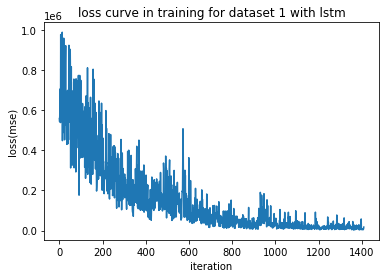

152975.0 989611.0 3179.8481
[3565911.5   1377533.8    881082.94   278528.2    160182.52    64690.133
   58604.438]


In [45]:
show_train_process(losses_train_1,losses_test_1,'dataset 1 with lstm')

In [20]:
print('with out scaler')
X1_wo = scale_numerical_cols(d1,method='')
train_df,test_df = get_train_test_split(X1_wo)
model1,(losses_train_1,losses_test_1) = train_model(train_df,test_df,lr=lr,bsz=bsz,epochs=epochs,
                                                   hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features)

with out scaler
(24362, 10) (6091, 10)
(6091, 1) (6091, 1)
Epoch 0: test RMSE 781.7126 test MAE 304.6148 R2 -0.1759
(6091, 1) (6091, 1)
Epoch 5: test RMSE 431.3487 test MAE 172.0335 R2 0.6420
(6091, 1) (6091, 1)
Epoch 10: test RMSE 297.0891 test MAE 130.6597 R2 0.8302
(6091, 1) (6091, 1)
Epoch 15: test RMSE 245.1504 test MAE 99.3527 R2 0.8843
(6091, 1) (6091, 1)
Epoch 20: test RMSE 217.4149 test MAE 105.2722 R2 0.9090
(6091, 1) (6091, 1)
Epoch 25: test RMSE 255.3044 test MAE 125.0607 R2 0.8746
(6091, 1) (6091, 1)
Epoch 29: test RMSE 196.7025 test MAE 97.8795 R2 0.9255


In [50]:
print('using CNN')
model1,(losses_train_cnn_1,losses_test_cnn_1) = train_model(train_df,test_df,lr=lr,bsz=bsz,epochs=epochs,
                                                   hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features,
                                                   model_type='cnn')

using CNN
step:46/47 loss:416164.0625
(6091, 1) (6091, 1)
Epoch 0: test RMSE 523.0601 test MAE 248.2567 R2 0.4517
step:46/47 loss:331290.1875
step:46/47 loss:132439.015625
step:46/47 loss:232953.09375
step:46/47 loss:47029.515625
step:46/47 loss:42739.60546875
(6091, 1) (6091, 1)
Epoch 5: test RMSE 247.4417 test MAE 122.6850 R2 0.8773
step:46/47 loss:118679.703125
step:46/47 loss:111973.359375
step:46/47 loss:104594.1015625
step:46/47 loss:44801.3828125
step:46/47 loss:130284.0625
(6091, 1) (6091, 1)
Epoch 10: test RMSE 270.3530 test MAE 115.7196 R2 0.8535
step:46/47 loss:62745.34375
step:46/47 loss:27945.87109375
step:46/47 loss:25679.4453125
step:46/47 loss:49384.70703125
step:46/47 loss:23344.82421875
(6091, 1) (6091, 1)
Epoch 15: test RMSE 197.1670 test MAE 91.7826 R2 0.9221
step:46/47 loss:114942.09375
step:46/47 loss:61885.296875
step:46/47 loss:57260.4140625
step:46/47 loss:81869.9296875
step:46/47 loss:52866.6875
(6091, 1) (6091, 1)
Epoch 20: test RMSE 212.9266 test MAE 107.259

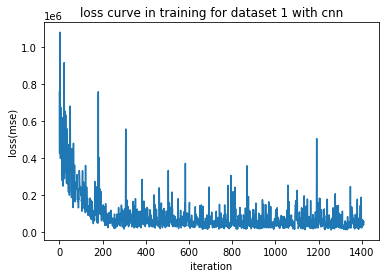

88475.62 1078118.5 10229.026
[1639298.1   368734.1   438850.56  233726.06  271294.44  203782.47
  219962.9 ]


In [110]:
show_train_process(losses_train_cnn_1,losses_test_cnn_1,'dataset 1 with cnn')

In [104]:
print('using DNN')
model1,(losses_train_dnn_1,losses_test_dnn_1) = train_model(train_df,test_df,lr=lr,bsz=bsz,epochs=epochs,
                                                   hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features,
                                                   model_type='dnn')

using DNN
step:46/47 loss:776294.75
(6091, 1) (6091, 1)
Epoch 0: test RMSE 774.7316 test MAE 324.4271 R2 -0.2028
step:46/47 loss:636847.0
step:46/47 loss:579557.75
step:46/47 loss:312876.90625
step:46/47 loss:362565.0625
step:46/47 loss:412367.75
(6091, 1) (6091, 1)
Epoch 5: test RMSE 638.7837 test MAE 284.1178 R2 0.1823
step:46/47 loss:570501.375
step:46/47 loss:378084.59375
step:46/47 loss:291874.375
step:46/47 loss:528230.4375
step:46/47 loss:390247.125
(6091, 1) (6091, 1)
Epoch 10: test RMSE 637.3757 test MAE 294.8913 R2 0.1859
step:46/47 loss:471026.15625
step:46/47 loss:281309.125
step:46/47 loss:440601.15625
step:46/47 loss:329593.25
step:46/47 loss:601798.75
(6091, 1) (6091, 1)
Epoch 15: test RMSE 635.9211 test MAE 293.9981 R2 0.1896
step:46/47 loss:239660.40625
step:46/47 loss:383491.625
step:46/47 loss:637693.4375
step:46/47 loss:479855.21875
step:46/47 loss:189833.125
(6091, 1) (6091, 1)
Epoch 20: test RMSE 634.3421 test MAE 295.5846 R2 0.1936
step:46/47 loss:405227.0625
ste

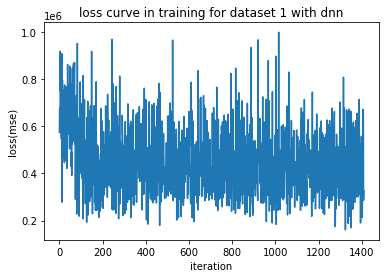

447403.12 999930.06 160253.06
[3594473.8 2450212.8 2439797.  2430184.5 2418265.2 2391561.  2389659.5]


In [109]:
show_train_process(losses_train_dnn_1,losses_test_dnn_1,'dataset 1 with dnn')

In [ ]:
# train_df_2,test_df_2 = get_train_test_split(X2)

In [46]:
lr=1e-3
bsz=512
epochs=30
hidden_dim,num_layers,in_features=64,4,7
model2,(losses_train_2,losses_test_2) = train_model(train_df_2,test_df_2,
                                        lr=lr,bsz=bsz,epochs=epochs,
                                        hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features)

step:126/127 loss:360903.4375
(16351, 1) (16351, 1)
Epoch 0: test RMSE 700.1442 test MAE 292.2617 R2 0.2169
step:126/127 loss:505505.09375
step:126/127 loss:1026268.125
step:126/127 loss:281823.5
step:126/127 loss:196444.28125
step:126/127 loss:764432.0625
(16351, 1) (16351, 1)
Epoch 5: test RMSE 536.2890 test MAE 190.2272 R2 0.5406
step:126/127 loss:507632.75
step:126/127 loss:237680.625
step:126/127 loss:763137.875
step:126/127 loss:833836.875
step:126/127 loss:48327.3359375
(16351, 1) (16351, 1)
Epoch 10: test RMSE 358.5669 test MAE 131.4452 R2 0.7946
step:126/127 loss:75927.375
step:126/127 loss:29513.3515625
step:126/127 loss:41945.4765625
step:126/127 loss:212366.09375
step:126/127 loss:25561.556640625
(16351, 1) (16351, 1)
Epoch 15: test RMSE 257.5129 test MAE 89.3102 R2 0.8941
step:126/127 loss:65308.171875
step:126/127 loss:79725.71875
step:126/127 loss:116581.046875
step:126/127 loss:42063.65625
step:126/127 loss:55724.7421875
(16351, 1) (16351, 1)
Epoch 20: test RMSE 276.972

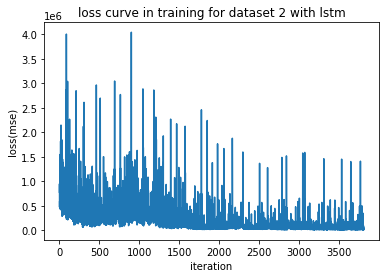

229057.98 4045436.8 5424.3223
[7848070.  4595975.  2055227.9 1059733.2 1226877.2  594673.3  664016.1]


In [47]:
show_train_process(losses_train_2,losses_test_2,'dataset 2 with lstm')

In [48]:
print('for merged dataset')
X3 = scale_numerical_cols(d3)
train_df_3,test_df_3 = get_train_test_split(X3)
print(train_df_3.shape,test_df_3.shape)
lr=1e-3
bsz=512
epochs=30
hidden_dim,num_layers,in_features=64,4,7
model3,(losses_train_3,losses_test_3) = train_model(train_df_3,test_df_3,
                                        lr=lr,bsz=bsz,epochs=epochs,
                                        hidden_dim=hidden_dim,num_layers=num_layers,in_features=in_features)

for merged dataset
(89764, 10) (22442, 10)
(89764, 10) (22442, 10)
step:174/175 loss:262089.15625
(22442, 1) (22442, 1)
Epoch 0: test RMSE 753.2686 test MAE 281.8441 R2 0.2150
step:174/175 loss:391469.28125
step:174/175 loss:255294.8125
step:174/175 loss:328585.1875
step:174/175 loss:146996.3125
step:174/175 loss:186954.21875
(22442, 1) (22442, 1)
Epoch 5: test RMSE 643.4390 test MAE 264.9435 R2 0.4272
step:174/175 loss:234058.546875
step:174/175 loss:708636.125
step:174/175 loss:142951.25
step:174/175 loss:376382.1875
step:174/175 loss:1446927.0
(22442, 1) (22442, 1)
Epoch 10: test RMSE 653.8599 test MAE 238.3160 R2 0.4085
step:174/175 loss:286580.03125
step:174/175 loss:210596.21875
step:174/175 loss:424323.71875
step:174/175 loss:299969.6875
step:174/175 loss:375324.40625
(22442, 1) (22442, 1)
Epoch 15: test RMSE 639.6487 test MAE 251.9269 R2 0.4339
step:174/175 loss:210766.96875
step:174/175 loss:227508.0
step:174/175 loss:120524.9375
step:174/175 loss:193254.265625
step:174/175 lo

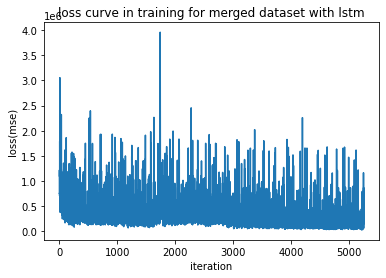

336803.94 3958346.5 27904.637
[12480629.   9112527.   9450783.   8992946.   6890051.5  4960741.
  4952419. ]


In [49]:
show_train_process(losses_train_3,losses_test_3,'merged dataset with lstm')

## 2.3 DNN Models Structure

In [100]:
lstm_model = LSTMModel(hidden_dim=64,num_layers=2,in_features=7)
cnn_model = CNNModel(hidden_dim=64,in_features=7)
dnn_model = DNNModel(hidden_dim=64,in_features=7)

In [85]:
! pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [101]:
summary(lstm_model,input_data=[torch.ones((1,7),dtype=torch.float32),torch.ones((1,16,2),dtype=torch.float32)])

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [1, 1]                    --
├─LSTM: 1-1                              [1, 16, 64]               50,688
├─Linear: 1-2                            [1, 32]                   256
├─Linear: 1-3                            [1, 128]                  12,416
├─Linear: 1-4                            [1, 64]                   8,256
├─Linear: 1-5                            [1, 1]                    65
Total params: 71,681
Trainable params: 71,681
Non-trainable params: 0
Total mult-adds (M): 0.83
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29
Estimated Total Size (MB): 0.30

In [102]:
summary(cnn_model,input_data=[torch.ones((1,7),dtype=torch.float32),torch.ones((1,16,2),dtype=torch.float32)])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Conv1d: 1-1                            [1, 64, 15]               320
├─MaxPool1d: 1-2                         [1, 64, 7]                --
├─Conv1d: 1-3                            [1, 64, 6]                8,256
├─MaxPool1d: 1-4                         [1, 64, 3]                --
├─Linear: 1-5                            [1, 32]                   256
├─Linear: 1-6                            [1, 128]                  12,416
├─Linear: 1-7                            [1, 64]                   8,256
├─Linear: 1-8                            [1, 1]                    65
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
Total mult-adds (M): 0.08
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.12
Estimated Total Size (MB): 0.13

In [103]:
summary(dnn_model,input_data=[torch.ones((1,7),dtype=torch.float32),torch.ones((1,16,2),dtype=torch.float32)])

Layer (type:depth-idx)                   Output Shape              Param #
DNNModel                                 [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Linear: 1-2                            [1, 128]                  8,320
├─Linear: 1-3                            [1, 64]                   8,256
├─Linear: 1-4                            [1, 1]                    65
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07